## Variational Quantum Classifier

This notebook will walk you through the training of a variational quantum classifier.

In [1]:
import pandas as pd
import numpy as np
from pennylane import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import time
start = time.time()

In [2]:
# Read out CSV and sets/samples creation

df = pd.read_csv('synthetic_data.csv', sep=',')
df = df.astype(float)
# Review the information related to the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      50000 non-null  float64
 1   X2      50000 non-null  float64
 2   X3      50000 non-null  float64
 3   X4      50000 non-null  float64
 4   X5      50000 non-null  float64
 5   X6      50000 non-null  float64
 6   X7      50000 non-null  float64
 7   X8      50000 non-null  float64
 8   X9      50000 non-null  float64
 9   X10     50000 non-null  float64
 10  y       50000 non-null  float64
dtypes: float64(11)
memory usage: 4.2 MB


In [3]:
df.head()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y
0,1.0,0.031390,0.031390,0.031390,0.031390,0.031390,0.031390,0.031390,0.031390,0.031390,1.0
1,1.0,5.234565,5.234565,5.234565,5.234565,5.234565,5.234565,5.234565,5.234565,5.234565,1.0
2,1.0,9.354209,9.354209,9.354209,9.354209,9.354209,9.354209,9.354209,9.354209,9.354209,1.0
3,1.0,-8.133407,-8.133407,-8.133407,-8.133407,-8.133407,-8.133407,-8.133407,-8.133407,-8.133407,0.0
4,1.0,-5.471547,-5.471547,-5.471547,-5.471547,-5.471547,-5.471547,-5.471547,-5.471547,-5.471547,0.0


In [4]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y
count,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.0,0.028783,0.028783,0.028783,0.028783,0.028783,0.028783,0.028783,0.028783,0.028783,0.478760
std,0.0,5.761384,5.761384,5.761384,5.761384,5.761384,5.761384,5.761384,5.761384,5.761384,0.499554
min,1.0,-9.999899,-9.999899,-9.999899,-9.999899,-9.999899,-9.999899,-9.999899,-9.999899,-9.999899,0.000000
25%,1.0,-4.926806,-4.926806,-4.926806,-4.926806,-4.926806,-4.926806,-4.926806,-4.926806,-4.926806,0.000000
50%,1.0,0.057610,0.057610,0.057610,0.057610,0.057610,0.057610,0.057610,0.057610,0.057610,0.000000
75%,1.0,4.996073,4.996073,4.996073,4.996073,4.996073,4.996073,4.996073,4.996073,4.996073,1.000000
max,1.0,9.999712,9.999712,9.999712,9.999712,9.999712,9.999712,9.999712,9.999712,9.999712,1.000000


Split dataset into training and test, with a 70/30 fraction.

In [5]:
train,test = train_test_split(df, test_size=0.30, random_state=2)
train_set = train
test_set = test
train_set = train_set.sample(160)
test_set = test_set.sample(40)
np.random.seed(42)

In [6]:
# Separation of labels

x_train = train_set
y_train = train_set[['y']]

x_test = test_set
y_test = test_set[['y']]

Reduce dimensions using PCA to reduce the number of qubits used, since we will use the `angle encoding` method, that scales with the number of features.

In [7]:
n_dim = 2
pca = PCA(n_components=n_dim)
pca.fit(x_train)

x_train = pca.transform(x_train)

pca.fit(x_test)
x_test = pca.transform(x_test)

In [8]:
# Normalize

std_scale = StandardScaler().fit(x_train)
data = std_scale.transform(x_train)

std_scale = StandardScaler().fit(x_test)
x_test = std_scale.transform(x_test)

In [9]:
# Review the balance of the target variable in train

y_train.value_counts(normalize=True)*100

y  
1.0    55.0
0.0    45.0
dtype: float64

In [10]:
# Review the balance of the target variable in test

y_test.value_counts(normalize=True)*100

y  
0.0    60.0
1.0    40.0
dtype: float64

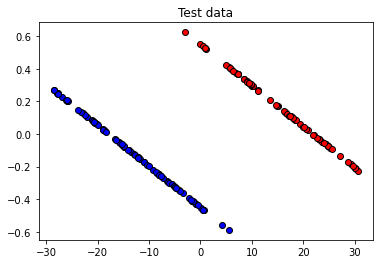

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(x_train[:, 0][y_train['y'] == 1], x_train[:, 1][y_train['y'] == 1], c="b", marker="o", edgecolors="k")
plt.scatter(x_train[:, 0][y_train['y'] == 0], x_train[:, 1][y_train['y'] == 0], c="r", marker="o", edgecolors="k")
plt.title("Test data")
plt.show()

Build the circuit!

In [12]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

Generate a set of random parameters to initialize the circuit.

In [13]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

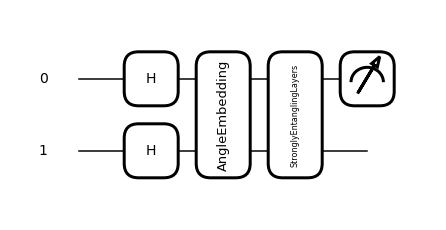

In [14]:
%%capture --no-display
drawer = qml.draw_mpl(circuit)
print(drawer(weights_init,data[0]))

In [15]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [16]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [17]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [18]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

Normalize labels so that they are [-1,1]

In [19]:
Y = np.array(y_train.values[:,0] * 2 - np.ones(len(y_train.values[:,0])), requires_grad = False)  # shift label from {0, 1} to {-1, 1}
X = np.array(data, requires_grad=False)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-1.11087556, requires_grad=False), tensor(0.07222385, requires_grad=False)], Y =  1
X = [tensor(-1.54952209, requires_grad=False), tensor(0.77596637, requires_grad=False)], Y =  1
X = [tensor(0.89795482, requires_grad=False), tensor(0.64937756, requires_grad=False)], Y = -1
X = [tensor(-0.2833601, requires_grad=False), tensor(-1.25540047, requires_grad=False)], Y =  1
X = [tensor(-0.71182393, requires_grad=False), tensor(-0.56799458, requires_grad=False)], Y =  1


In [20]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [21]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0

for it in range(5):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

New best
Iter:     1 | Cost: 1.0412915 | Accuracy: 0.5687500 
New best
Iter:     2 | Cost: 0.8594871 | Accuracy: 0.6250000 
New best
Iter:     3 | Cost: 0.6605213 | Accuracy: 0.6625000 
New best
Iter:     4 | Cost: 0.4317071 | Accuracy: 0.8375000 
New best
Iter:     5 | Cost: 0.2843430 | Accuracy: 1.0000000 


Change labels of test dataset

In [28]:
Yte = np.array(y_test.values[:,0] * 2 - np.ones(len(y_test.values[:,0])), requires_grad = False)
Xte = np.array(normalize(x_test), requires_grad=False)

In [35]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(-1.0*Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, -1.0*Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.2912114589590978, Accuracy: 100.0%


In [36]:
# Print the classification report and important metrics

print(metrics.classification_report(predictions,-1.0*Yte))
print(metrics.precision_score(predictions,-1.0*Yte))
print(metrics.recall_score(predictions,-1.0*Yte))
print(metrics.f1_score(predictions,-1.0*Yte))
print(metrics.balanced_accuracy_score(predictions,-1.0*Yte))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        24

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

1.0
1.0
1.0
1.0
